# Statistical models in R
This notebook is covering:
1. Cointegration

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

In [2]:
# rpy2 is a Python package that allows you to run R code from Python
%pip install rpy2

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load the rpy2 extension to use R in Jupyter
%load_ext rpy2.ipython

The magic function `%%R` is used for running R code in Jupyter

In [4]:
%%R
source("cointegration.r")
hub1_name <- "ttf"
hub2_name <- "nbp"
rolling_window <- 250
validation_size <- 250
test_size <- 250
window_size <- 5

Loading required package: rugarch
Loading required package: parallel

Attaching package: ‘rugarch’

The following object is masked from ‘package:stats’:

    sigma



In [5]:
%%R
cointegration_results <- cointegration(hub1_name, hub2_name, rolling_window, validation_size, test_size, window_size, model = "ols", garch_model = "sGARCH", garch_order = c(1,1), garch_dist="norm", save=TRUE)

In [6]:
%%R
cointegration_results

           Date       ttf        nbp         alpha      beta      Sigma
1    2018-10-01  27.44300  28.877126            NA        NA         NA
2    2018-10-02  27.25700  28.446208            NA        NA         NA
3    2018-10-03  27.11400  28.430963            NA        NA         NA
4    2018-10-04  27.47100  28.728898            NA        NA         NA
5    2018-10-05  27.90200  29.268868            NA        NA         NA
6    2018-10-08  27.21800  28.393256            NA        NA         NA
7    2018-10-09  26.83500  28.048454            NA        NA         NA
8    2018-10-10  26.22000  27.399205            NA        NA         NA
9    2018-10-11  25.75900  26.909443            NA        NA         NA
10   2018-10-12  26.62800  28.021074            NA        NA         NA
11   2018-10-15  26.62500  27.997494            NA        NA         NA
12   2018-10-16  26.32800  27.435882            NA        NA         NA
13   2018-10-17  25.94200  27.112294            NA        NA    

In [21]:
%%R
model <- "sGARCH"
dist <- "norm"
run <- cointegration_volatilities(cointegration_results, hub1_name, hub2_name, model, dist, validation_size, test_size, window_size)

In [7]:
%%R
# Normal for loop setup


pairs <- list(c("ttf", "the"), 
        c("ttf", "nbp"), 
        c("the", "nbp")
)
window_sizes <- c(5)
models <- c("sGARCH", "gjrGARCH")
distributions <- c("norm", "sstd")

# Iterate over each combination of parameters
for (i in 1:length(pairs)) {
    for (j in 1:length(models)) {
        for (d in 1:length(distributions)) {
            for (k in 1:length(window_sizes)) {
                pair <- pairs[[i]]
                hub1_name <- pair[1]
                hub2_name <- pair[2]
                window_size <- window_sizes[k]
                garch_model <- models[j]
                dist <- distributions[d]

                # Print progress for debugging
                print(paste("Starting", hub1_name, hub2_name, garch_model, dist, window_size))

                # Run the main task and handle errors with tryCatch
                tryCatch({
                    cointegration_results <- cointegration(
                        hub1_name,
                        hub2_name,
                        rolling_window,
                        validation_size,
                        test_size,
                        window_size,
                        model = "ols",
                        garch_model = garch_model,
                        garch_order = c(2, 1),
                        garch_dist = dist,
                        save = TRUE
                    )
                    # Store the result in the list
                    print(paste("Task completed for", hub1_name, hub2_name, garch_model, dist))
                }, error = function(e) {
                    # Print error message for debugging
                    print(paste("Error in task", i, j, d, k, ":", e$message))
                })
            }
        }
    }
}



[1] "Starting ttf the sGARCH norm 5"


[1] "Task completed for ttf the sGARCH norm"
[1] "Starting ttf the sGARCH sstd 5"
[1] "Task completed for ttf the sGARCH sstd"
[1] "Starting ttf the gjrGARCH norm 5"
[1] "Task completed for ttf the gjrGARCH norm"
[1] "Starting ttf the gjrGARCH sstd 5"
[1] "Task completed for ttf the gjrGARCH sstd"
[1] "Starting ttf nbp sGARCH norm 5"
[1] "Task completed for ttf nbp sGARCH norm"
[1] "Starting ttf nbp sGARCH sstd 5"
[1] "Task completed for ttf nbp sGARCH sstd"
[1] "Starting ttf nbp gjrGARCH norm 5"
[1] "Task completed for ttf nbp gjrGARCH norm"
[1] "Starting ttf nbp gjrGARCH sstd 5"
[1] "Task completed for ttf nbp gjrGARCH sstd"
[1] "Starting the nbp sGARCH norm 5"
[1] "Task completed for the nbp sGARCH norm"
[1] "Starting the nbp sGARCH sstd 5"
[1] "Task completed for the nbp sGARCH sstd"
[1] "Starting the nbp gjrGARCH norm 5"
[1] "Task completed for the nbp gjrGARCH norm"
[1] "Starting the nbp gjrGARCH sstd 5"
[1] "Task completed for the nbp gjrGARCH sstd"
$ttf_the_sGARCH_norm
        

In [9]:
%%R
if (require("foreach") == FALSE) {
  install.packages("foreach")
  library(foreach)
}
if (require("doParallel") == FALSE) {
  install.packages("doParallel")
  library(doParallel)
}

Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators


In [10]:
%%R
source("cointegration.r")
num_cores <- 12 
cl <- makeCluster(num_cores)
registerDoParallel(cl)
clusterEvalQ(cl, library(tsDyn))
clusterEvalQ(cl, library(rugarch))

clusterEvalQ(cl, source("cointegration.r"))

clusterExport(cl, varlist=c("cointegration", "cointegration_volatilities", "garch_predictions", "validation_size", "test_size"))

pairs <- list(c("ttf", "the"), 
        c("ttf", "nbp"), 
        c("the", "nbp")
)
window_sizes <- c(5)
models <- c("sGARCH", "gjrGARCH")
distributions <- c("norm", "sstd")

# Use foreach to parallelize the loop
results <- foreach(i = 1:length(pairs), .combine = c, .multicombine = TRUE) %:%
            foreach(j = 1:length(models), .combine = c) %:%
            foreach(d = 1:length(distributions), .combine = c) %:%
           foreach(k = 1:length(window_sizes), .combine = c) %dopar% {

               pair <- pairs[[i]]
               hub1_name <- pair[1]
               hub2_name <- pair[2]
               window_size <- window_sizes[k]
                garch_model <- models[j]
                dist <- distributions[d]
               print(paste("Starting", hub1_name, hub2_name,garch_model, dist, window_size))
               cointegration_results <- cointegration(hub1_name, hub2_name, rolling_window, validation_size, test_size, window_size, model = "ols", garch_model = garch_model, garch_order = c(2,1), garch_dist=dist, save=TRUE)
              paste("Task", i,j, "done")
           }
# Stop the parallel cluster
stopCluster(cl)

In [113]:
%%R
model

           Date       ttf        the      beta

      hub_diff
1    2018-10-01  27.44300  27.400000        NA            NA
2    2018-10-02  27.25700  27.341000        NA            NA
3    2018-10-03  27.11400  27.233000        NA            NA
4    2018-10-04  27.47100  27.584000        NA            NA
5    2018-10-05  27.90200  28.170000        NA            NA
6    2018-10-08  27.21800  27.219000        NA            NA
7    2018-10-09  26.83500  26.955000        NA            NA
8    2018-10-10  26.22000  26.316000        NA            NA
9    2018-10-11  25.75900  25.863000        NA            NA
10   2018-10-12  26.62800  26.698000        NA            NA
11   2018-10-15  26.62500  26.756000        NA            NA
12   2018-10-16  26.32800  26.330000        NA            NA
13   2018-10-17  25.94200  26.001000        NA            NA
14   2018-10-18  26.02500  26.145000        NA            NA
15   2018-10-19  26.85800  26.966000        NA            NA
16   2018-10-22  26.11400  26.277000        NA            NA
17   2018

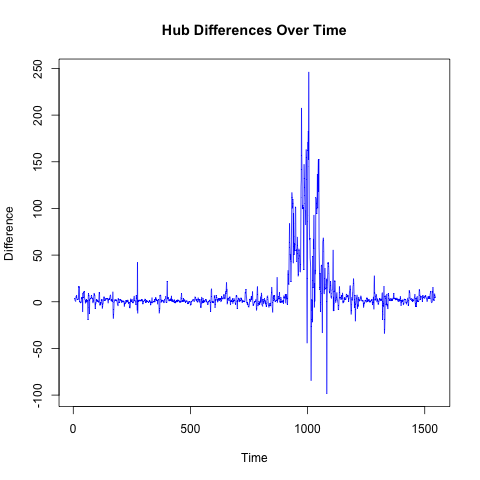

In [126]:
%%R
plot(model$hub_diff, type='l', col='blue', main='Hub Differences Over Time', xlab='Time', ylab='Difference')

In [72]:
%%R
hub_prices <- list(
    nbp = read.csv("../../data/interpolated/nbp_close_interpolated.csv"),
    peg = read.csv("../../data/interpolated/peg_close_interpolated.csv"),
    the = read.csv("../../data/interpolated/the_close_interpolated.csv"),
    ttf = read.csv("../../data/interpolated/ttf_close_interpolated.csv"),
    ztp = read.csv("../../data/interpolated/ztp_close_interpolated.csv")
)

hub1 <- hub_prices[[hub1_name]]
hub2 <- hub_prices[[hub2_name]]

hubs <- data.frame(hub1 = hub1$CLOSE, hub2 = hub2$CLOSE)

i = 723
lags = 6

hub_train <- hubs[(i - rolling_window+1):i, ]
vecm <- VECM(hub_train, lag = lags, r = 1, include = "none", estim = "ML")
beta <- (-1) * vecm$model.specific$beta[2, 1]

In [73]:
%%R
hub_train

        hub1      hub2
224 12.07500 12.541854
225 12.02400 12.456157
226 11.42000 11.855567
227 11.85900 12.386435
228 11.18000 11.685651
229 11.22300 11.644803
230 10.95500 11.393469
231 10.78600 11.213987
232 11.21700 11.782270
233 11.41400 11.946817
234 10.99100 11.555099
235 10.58300 11.228564
236 10.31300 10.956807
237 10.07000 10.685051
238 10.23600 10.819059
239 10.71600 11.303825
240 12.79700 12.475145
241 11.84800 11.470921
242 12.09800 11.848889
243 11.95800 11.696826
244 12.23600 12.036823
245 12.35100 12.146261
246 12.23600 11.982372
247 14.40400 14.220259
248 14.35500 14.148934
249 14.46300 14.268277
250 14.71100 14.690100
251 15.33400 15.299346
252 13.44100 13.520710
253 12.43400 12.525108
254 12.25500 12.445032
255 12.71100 12.857775
256 12.24300 12.441901
257 12.33900 12.447854
258 11.94900 11.910324
259 12.04400 11.796909
260 11.93900 11.748801
261 16.39200 16.607806
262 16.76200 17.045225
263 16.00400 16.206277
264 16.00800 16.145958
265 15.76900 16.051158
266 15.5070

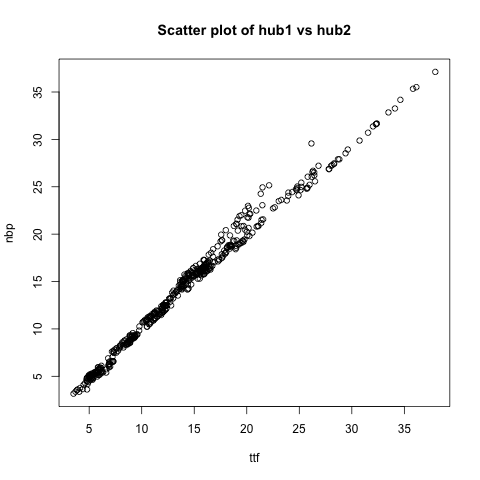

In [74]:
%%R
plot(hub_train$hub1, hub_train$hub2, xlab=hub1_name, ylab=hub2_name, main="Scatter plot of hub1 vs hub2")

In [70]:
%%R
summary(vecm)

#############
###Model VECM 
#############
Full sample size: 500 	End sample size: 493
Number of variables: 2 	Number of estimated slope parameters 26
AIC -2139.046 	BIC -2025.633 	SSR 450.7137
Cointegrating vector (estimated by ML):
   hub1       hub2
r1    1 -0.6587209


              ECT               hub1 -1            hub2 -1          
Equation hub1 0.0182(0.0064)**  -0.6024(0.1936)**  0.5278(0.1810)** 
Equation hub2 0.0162(0.0068)*   -0.4486(0.2061)*   0.4054(0.1926)*  
              hub1 -2            hub2 -2             hub1 -3            
Equation hub1 0.1553(0.1983)     -0.2056(0.1842)     -0.0648(0.1983)    
Equation hub2 0.2109(0.2111)     -0.2515(0.1961)     -0.0971(0.2110)    
              hub2 -3            hub1 -4            hub2 -4            
Equation hub1 0.0189(0.1844)     0.0447(0.1985)     -0.1553(0.1845)    
Equation hub2 0.0541(0.1963)     0.0524(0.2112)     -0.1624(0.1964)    
              hub1 -5             hub2 -5             hub1 -6            
Equation h

In [63]:
%%R
beta

[1] -12.45122


In [64]:
%%R
train_size <- nrow(hubs) - test_size - window_size
hub_train <- hubs[1:train_size + 1, ]

aics <- c()
bics <- c()
max_lag <- 20
for (p in 1:max_lag) {
vecm <- VECM(hub_train, lag = p,  r = 1, include = "none", estim = "ML")
aics <- c(aics, AIC(vecm))
bics <- c(bics, BIC(vecm))
}
lags <- which.min(bics)
lags    

[1] 5


In [5]:
%%R
pairs <- list(c("ttf", "the"), 
            c("ttf", "nbp"), 
            c("the", "nbp")
            )
window_sizes <- c(5, 10)
for (i in 1:length(pairs)) {
    for(k in 1:length(window_sizes)) {
        pair <- pairs[[i]]
        hub1_name <- pair[1]
        hub2_name <- pair[2]
        window_size <- window_sizes[k]
        vecm_system(hub1_name, hub2_name, validation_size, test_size, window_size, verbose=FALSE, save=TRUE)
        print(paste("Finished", hub1_name, hub2_name, window_size))
    }
}

[1] "Finished ttf the 5"
[1] "Finished ttf the 10"
[1] "Finished ttf nbp 5"
[1] "Finished ttf nbp 10"
[1] "Finished the nbp 5"
[1] "Finished the nbp 10"


In [6]:
%%R
vecm_output <- vecm_system("the", "nbp", validation_size, test_size, 5, verbose=TRUE, save=TRUE)

[1] "Selected number of lags: 5"
[1] "Pair: the | nbp"
[1] "Window Size: 5"
[1] "Test Size: 250"
[1] "the: Mean Absolute Error: 2.071"
[1] "the: Root Mean Squared Error: 2.927"
[1] "nbp: Mean Absolute Error: 2.137"
[1] "nbp: Root Mean Squared Error: 3.034"


In [7]:
%%R
training_model <- vecm_training_model(hub1_name, hub2_name, test_size, window_size)
summary(training_model)

#############
###Model VECM 
#############
Full sample size: 1285 	End sample size: 1279
Number of variables: 2 	Number of estimated slope parameters 24
AIC 6868.471 	BIC 6997.317 	SSR 87041.64
Cointegrating vector (estimated by ML):
   hub1     hub2
r1    1 -1.38433


              ECT               Intercept          hub1 -1          
Equation hub1 0.0220(0.0118).   0.2362(0.2023)     0.2716(0.0663)***
Equation hub2 0.0414(0.0122)*** 0.4365(0.2105)*    0.3090(0.0690)***
              hub2 -1             hub1 -2            hub2 -2           
Equation hub1 -0.1052(0.0641)     -0.1819(0.0661)**  0.0513(0.0638)    
Equation hub2 -0.1695(0.0667)*    -0.2080(0.0687)**  0.0747(0.0664)    
              hub1 -3            hub2 -3           hub1 -4          
Equation hub1 -0.2619(0.0661)*** 0.2494(0.0637)*** 0.2035(0.0665)** 
Equation hub2 -0.2687(0.0688)*** 0.2397(0.0663)*** 0.2438(0.0692)***
              hub2 -4             hub1 -5            hub2 -5          
Equation hub1 -0.0484(0.0641)

In [8]:
%%R
hub1_predictions <- vecm_output$predictions$hub1
hub1_actuals <- vecm_output$actuals$hub1
hub2_predictions <- vecm_output$predictions$hub2
hub2_actuals <- vecm_output$actuals$hub2


In [9]:
%%R
hub1_forecast_comparison <- data.frame(
  Actual = hub1_actuals,
  Forecasted = hub1_predictions
)

In [10]:
%R -o hub1_forecast_comparison
%R -o hub1_name

hub1_forecast_comparison = hub1_forecast_comparison

actual_trace = go.Scatter(
    x=hub1_forecast_comparison.index,
    y=hub1_forecast_comparison['Actual'],
    mode='lines',
    name='Actual Prices'
)

forecasted_trace = go.Scatter(
    x=hub1_forecast_comparison.index,
    y=hub1_forecast_comparison['Forecasted'],
    mode='lines',
    name='Forecasted Prices'
)

# Create the plot
layout = go.Layout(
    title= hub1_name.item() + ': VECM Actual vs Forecasted Prices',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Price'),
)

fig = go.Figure(data=[actual_trace, forecasted_trace], layout=layout)
fig.show()


In [11]:
%%R
hub2_forecast_comparison <- data.frame(
  Actual = hub2_actuals,
  Forecasted = hub2_predictions
)

In [12]:
%R -o hub2_forecast_comparison
%R -o hub2_name

hub2_forecast_comparison = hub2_forecast_comparison

actual_trace = go.Scatter(
    x=hub2_forecast_comparison.index,
    y=hub2_forecast_comparison['Actual'],
    mode='lines',
    name='Actual Prices'
)

forecasted_trace = go.Scatter(
    x=hub2_forecast_comparison.index,
    y=hub2_forecast_comparison['Forecasted'],
    mode='lines',
    name='Forecasted Prices'
)

# Create the plot
layout = go.Layout(
    title= hub2_name.item() + ': VECM Actual vs Forecasted Prices',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Price'),
)

fig = go.Figure(data=[actual_trace, forecasted_trace], layout=layout)
fig.show()
